# Gradient Boosting Machines (GBMs) with XGBoost

- toc:true
- categories:[ML]

## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

 Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Download Data

In [1]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [2]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Skipping, found downloaded files in "./rossmann-store-sales" (use force=True to force download)


In [3]:
data_dir = os.listdir('rossmann-store-sales/')

In [4]:
data_dir

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

In [5]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [6]:
ross_df

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0            1          5  2015-07-31   5263        555     1      1   
1            2          5  2015-07-31   6064        625     1      1   
2            3          5  2015-07-31   8314        821     1      1   
3            4          5  2015-07-31  13995       1498     1      1   
4            5          5  2015-07-31   4822        559     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
...              ...            ...  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1  

[1017209 rows x 9 columns]

In [7]:
test_df

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0          1      1          4  2015-09-17   1.0      1            0   
1          2      3          4  2015-09-17   1.0      1            0   
2          3      7          4  2015-09-17   1.0      1            0   
3          4      8          4  2015-09-17   1.0      1            0   
4          5      9          4  2015-09-17   1.0      1            0   
...      ...    ...        ...         ...   ...    ...          ...   
41083  41084   1111          6  2015-08-01   1.0      0            0   
41084  41085   1112          6  2015-08-01   1.0      0            0   
41085  41086   1113          6  2015-08-01   1.0      0            0   
41086  41087   1114          6  2015-08-01   1.0      0            0   
41087  41088   1115          6  2015-08-01   1.0      0            0   

       SchoolHoliday  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
41083              0  
41084              0  
41085              0  
41086              0  
41087              1  

[41088 rows x 8 columns]

In [8]:
store_df

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
...     ...       ...        ...                  ...   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
...                         ...                       ...     ...   
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                 NaN              NaN               NaN  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
...               ...              ...               ...  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec  

[1115 rows x 10 columns]

In [9]:
# merge df's

merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [10]:
merged_df

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0            1          5  2015-07-31   5263        555     1      1   
1            2          5  2015-07-31   6064        625     1      1   
2            3          5  2015-07-31   8314        821     1      1   
3            4          5  2015-07-31  13995       1498     1      1   
4            5          5  2015-07-31   4822        559     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0              1         c          a               1270.0   
1                  0              1         a          a                570.0   
2                  0              1         a          a              14130.0   
3                  0              1         c          c                620.0   
4                  0              1         a          a              29910.0   
...              ...            ...       ...        ...                  ...   
1017204            a              1         a          a               1900.0   
1017205            a              1         c          c               1880.0   
1017206            a              1         a          c               9260.0   
1017207            a              1         a          c                870.0   
1017208            a              1         d          c               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                              9.0                    2008.0       0   
1                             11.0                    2007.0       1   
2                             12.0                    2006.0       1   
3                              9.0                    2009.0       0   
4                              4.0                    2015.0       0   
...                            ...                       ...     ...   
1017204                        6.0                    2014.0       1   
1017205                        4.0                    2006.0       0   
1017206                        NaN                       NaN       0   
1017207                        NaN                       NaN       0   
1017208                        NaN                       NaN       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                    NaN              NaN               NaN  
1                   13.0           2010.0   Jan,Apr,Jul,Oct  
2                   14.0           2011.0   Jan,Apr,Jul,Oct  
3                    NaN              NaN               NaN  
4                    NaN              NaN               NaN  
...                  ...              ...               ...  
1017204             31.0           2013.0   Jan,Apr,Jul,Oct  
1017205              NaN              NaN               NaN  
1017206              NaN              NaN               NaN  
1017207              NaN              NaN               NaN  
1017208             22.0           2012.0  Mar,Jun,Sept,Dec  

[1017209 rows x 18 columns]

## Exploratory Data Analysis

## Preprocessing and Feature Engineering

In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

### Date

In [12]:
# convert date to datecolumn and extract different parts of date

def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekofYear'] = df.Date.dt.isocalendar().week

In [13]:
split_date(merged_df)
split_date(merged_test_df)

In [14]:
merged_df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1017204   1111          2 2013-01-01      0          0     0      0   
1017205   1112          2 2013-01-01      0          0     0      0   
1017206   1113          2 2013-01-01      0          0     0      0   
1017207   1114          2 2013-01-01      0          0     0      0   
1017208   1115          2 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0              1         c          a               1270.0   
1                  0              1         a          a                570.0   
2                  0              1         a          a              14130.0   
3                  0              1         c          c                620.0   
4                  0              1         a          a              29910.0   
...              ...            ...       ...        ...                  ...   
1017204            a              1         a          a               1900.0   
1017205            a              1         c          c               1880.0   
1017206            a              1         a          c               9260.0   
1017207            a              1         a          c                870.0   
1017208            a              1         d          c               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                              9.0                    2008.0       0   
1                             11.0                    2007.0       1   
2                             12.0                    2006.0       1   
3                              9.0                    2009.0       0   
4                              4.0                    2015.0       0   
...                            ...                       ...     ...   
1017204                        6.0                    2014.0       1   
1017205                        4.0                    2006.0       0   
1017206                        NaN                       NaN       0   
1017207                        NaN                       NaN       0   
1017208                        NaN                       NaN       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  Year  Month  Day  \
0                    NaN              NaN               NaN  2015      7   31   
1                   13.0           2010.0   Jan,Apr,Jul,Oct  2015      7   31   
2                   14.0           2011.0   Jan,Apr,Jul,Oct  2015      7   31   
3                    NaN              NaN               NaN  2015      7   31   
4                    NaN              NaN               NaN  2015      7   31   
...                  ...              ...               ...   ...    ...  ...   
1017204             31.0           2013.0   Jan,Apr,Jul,Oct  2013      1    1   
1017205              NaN              NaN               NaN  2013      1    1   
1017206              NaN              NaN               NaN  2013      1    1   
1017207              NaN              NaN               NaN  2013      1    1   
1017208             22.0           2012.0  Mar,Jun,Sept,Dec  2013      1    1   

         WeekofYear  
0                31  
1                31  
2                31  
3                31  
4                31  
...             ...  
1017204           1  
1017205           1  
1017206           1  
1017207           1  
1017208           1  

[1017209 rows x 22 columns]

### Store Open/Closed

In [15]:
# sales are 0 whenever store is closed

merged_df[merged_df.Open ==0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.



In [16]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition 

In [17]:
merged_df.sample(10)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
81229      950          3 2015-05-20   6709        619     1      1   
3394        50          2 2015-07-28   5115        390     1      1   
157691     477          4 2015-03-12   5154        394     1      0   
1013035    286          5 2013-01-04   4505        442     1      0   
366973     757          4 2014-08-14   4553        465     1      0   
40863      724          4 2015-06-25   5821        635     1      0   
416853     629          1 2014-06-23   7655        637     1      0   
213001      37          3 2015-01-21   4175        535     1      0   
228007     548          4 2015-01-08   4576        359     1      1   
59667      573          1 2015-06-08   3584        310     1      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
81229              0              0         a          a               8460.0   
3394               0              1         d          a               6260.0   
157691             0              0         d          a                770.0   
1013035            0              1         a          a               1460.0   
366973             0              1         a          c               3450.0   
40863              0              0         d          c               5900.0   
416853             0              0         d          a                510.0   
213001             0              0         c          a               4230.0   
228007             0              1         d          c               3760.0   
59667              0              0         a          a               1190.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
81229                         11.0                    1994.0       0   
3394                          11.0                    2009.0       0   
157691                         7.0                    2010.0       1   
1013035                        4.0                    2015.0       0   
366973                         NaN                       NaN       0   
40863                          NaN                       NaN       0   
416853                         7.0                    2014.0       1   
213001                        12.0                    2014.0       0   
228007                         2.0                    2009.0       0   
59667                         11.0                    2012.0       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  Year  Month  Day  \
81229                NaN              NaN               NaN  2015      5   20   
3394                 NaN              NaN               NaN  2015      7   28   
157691              35.0           2010.0   Jan,Apr,Jul,Oct  2015      3   12   
1013035              NaN              NaN               NaN  2013      1    4   
366973               NaN              NaN               NaN  2014      8   14   
40863                NaN              NaN               NaN  2015      6   25   
416853              23.0           2015.0  Mar,Jun,Sept,Dec  2014      6   23   
213001               NaN              NaN               NaN  2015      1   21   
228007               NaN              NaN               NaN  2015      1    8   
59667               36.0           2013.0   Jan,Apr,Jul,Oct  2015      6    8   

         WeekofYear  
81229            21  
3394             31  
157691           11  
1013035           1  
366973           33  
40863            26  
416853           26  
213001            4  
228007            2  
59667            24

we can use the columns CompetitionOpenSince[Month/Year] columns from store_df to compute the number of months for which a competitor has been open near the store.

In [18]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [19]:
comp_months(merged_df)
comp_months(merged_test_df)

In [20]:
merged_df.head(10)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   
5      6          5 2015-07-31   5651        589     1      1            0   
6      7          5 2015-07-31  15344       1414     1      1            0   
7      8          5 2015-07-31   8492        833     1      1            0   
8      9          5 2015-07-31   8565        687     1      1            0   
9     10          5 2015-07-31   7185        681     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   
5              1         a          a                310.0   
6              1         a          c              24000.0   
7              1         a          a               7520.0   
8              1         a          c               2030.0   
9              1         a          a               3160.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   
5                       12.0                    2013.0       0   
6                        4.0                    2013.0       0   
7                       10.0                    2014.0       0   
8                        8.0                    2000.0       0   
9                        9.0                    2009.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month  Day  \
0              NaN              NaN              NaN  2015      7   31   
1             13.0           2010.0  Jan,Apr,Jul,Oct  2015      7   31   
2             14.0           2011.0  Jan,Apr,Jul,Oct  2015      7   31   
3              NaN              NaN              NaN  2015      7   31   
4              NaN              NaN              NaN  2015      7   31   
5              NaN              NaN              NaN  2015      7   31   
6              NaN              NaN              NaN  2015      7   31   
7              NaN              NaN              NaN  2015      7   31   
8              NaN              NaN              NaN  2015      7   31   
9              NaN              NaN              NaN  2015      7   31   

   WeekofYear  CompetitionOpen  
0          31             82.0  
1          31             92.0  
2          31            103.0  
3          31             70.0  
4          31              3.0  
5          31             19.0  
6          31             27.0  
7          31              9.0  
8          31            179.0  
9          31             70.0

In [21]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']]


Date  CompetitionDistance  CompetitionOpenSinceYear  \
0       2015-07-31               1270.0                    2008.0   
1       2015-07-31                570.0                    2007.0   
2       2015-07-31              14130.0                    2006.0   
3       2015-07-31                620.0                    2009.0   
4       2015-07-31              29910.0                    2015.0   
...            ...                  ...                       ...   
1016776 2013-01-01                150.0                    2006.0   
1016827 2013-01-01                860.0                    1999.0   
1016863 2013-01-01                840.0                       NaN   
1017042 2013-01-01               1430.0                       NaN   
1017190 2013-01-01                720.0                    2002.0   

         CompetitionOpenSinceMonth  CompetitionOpen  
0                              9.0             82.0  
1                             11.0             92.0  
2                             12.0            103.0  
3                              9.0             70.0  
4                              4.0              3.0  
...                            ...              ...  
1016776                        9.0             76.0  
1016827                       10.0            159.0  
1016863                        NaN              0.0  
1017042                        NaN              0.0  
1017190                        3.0            130.0  

[844392 rows x 5 columns]

### Additional Promotion

In [22]:
merged_df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1016776    682          2 2013-01-01   3375        566     1      0   
1016827    733          2 2013-01-01  10765       2377     1      0   
1016863    769          2 2013-01-01   5035       1248     1      0   
1017042    948          2 2013-01-01   4491       1039     1      0   
1017190   1097          2 2013-01-01   5961       1405     1      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0              1         c          a               1270.0   
1                  0              1         a          a                570.0   
2                  0              1         a          a              14130.0   
3                  0              1         c          c                620.0   
4                  0              1         a          a              29910.0   
...              ...            ...       ...        ...                  ...   
1016776            a              1         b          a                150.0   
1016827            a              1         b          b                860.0   
1016863            a              1         b          b                840.0   
1017042            a              1         b          b               1430.0   
1017190            a              1         b          b                720.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                              9.0                    2008.0       0   
1                             11.0                    2007.0       1   
2                             12.0                    2006.0       1   
3                              9.0                    2009.0       0   
4                              4.0                    2015.0       0   
...                            ...                       ...     ...   
1016776                        9.0                    2006.0       0   
1016827                       10.0                    1999.0       0   
1016863                        NaN                       NaN       1   
1017042                        NaN                       NaN       0   
1017190                        3.0                    2002.0       0   

         Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month  Day  \
0                    NaN              NaN              NaN  2015      7   31   
1                   13.0           2010.0  Jan,Apr,Jul,Oct  2015      7   31   
2                   14.0           2011.0  Jan,Apr,Jul,Oct  2015      7   31   
3                    NaN              NaN              NaN  2015      7   31   
4                    NaN              NaN              NaN  2015      7   31   
...                  ...              ...              ...   ...    ...  ...   
1016776              NaN              NaN              NaN  2013      1    1   
1016827              NaN              NaN              NaN  2013      1    1   
1016863             48.0           2012.0  Jan,Apr,Jul,Oct  2013      1    1   
1017042              NaN              NaN              NaN  2013      1    1   
1017190              NaN              NaN              NaN  2013      1    1   

         WeekofYear  CompetitionOpen  
0                31             82.0  
1                31             92.0  
2                31            103.0  
3                31             70.0  
4                31              3.0  
...             ...              ...  
1016776           1             76.0  
1016827           1            159.0  
101686

add some additional columns to indicate how long a store has been running Promo2 and whether a new round of Promo2 starts in the current month.

In [23]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return -1
        else:
            return 0
        
    except Exception:
        return 0
    
    
def promo_cols(df):
    # month since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year-df.Promo2SinceYear) + (df.WeekofYear - df.Promo2SinceWeek) * 7/30.5
    df['Promo2Open'] = df['Promo2Open'] .map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    
    #wether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [24]:
promo_cols(merged_df)
promo_cols(merged_test_df)

merged_df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1016776    682          2 2013-01-01   3375        566     1      0   
1016827    733          2 2013-01-01  10765       2377     1      0   
1016863    769          2 2013-01-01   5035       1248     1      0   
1017042    948          2 2013-01-01   4491       1039     1      0   
1017190   1097          2 2013-01-01   5961       1405     1      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0              1         c          a               1270.0   
1                  0              1         a          a                570.0   
2                  0              1         a          a              14130.0   
3                  0              1         c          c                620.0   
4                  0              1         a          a              29910.0   
...              ...            ...       ...        ...                  ...   
1016776            a              1         b          a                150.0   
1016827            a              1         b          b                860.0   
1016863            a              1         b          b                840.0   
1017042            a              1         b          b               1430.0   
1017190            a              1         b          b                720.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                              9.0                    2008.0       0   
1                             11.0                    2007.0       1   
2                             12.0                    2006.0       1   
3                              9.0                    2009.0       0   
4                              4.0                    2015.0       0   
...                            ...                       ...     ...   
1016776                        9.0                    2006.0       0   
1016827                       10.0                    1999.0       0   
1016863                        NaN                       NaN       1   
1017042                        NaN                       NaN       0   
1017190                        3.0                    2002.0       0   

         Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month  Day  \
0                    NaN              NaN              NaN  2015      7   31   
1                   13.0           2010.0  Jan,Apr,Jul,Oct  2015      7   31   
2                   14.0           2011.0  Jan,Apr,Jul,Oct  2015      7   31   
3                    NaN              NaN              NaN  2015      7   31   
4                    NaN              NaN              NaN  2015      7   31   
...                  ...              ...              ...   ...    ...  ...   
1016776              NaN              NaN              NaN  2013      1    1   
1016827              NaN              NaN              NaN  2013      1    1   
1016863             48.0           2012.0  Jan,Apr,Jul,Oct  2013      1    1   
1017042              NaN              NaN              NaN  2013      1    1   
1017190              NaN              NaN              NaN  2013      1    1   

         WeekofYear  CompetitionOpen  Promo2Open  IsPromo2Month  
0                31             82.0    0.000000              0  
1                31             92.0   64.131148             -1  
2                31            103.0   51.901639             -1  
3                31             70.0    0.000000              0  
4                31        

In [25]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)


Date  Promo2  Promo2SinceYear  Promo2SinceWeek     PromoInterval  \
778123 2013-08-03       0              NaN              NaN               NaN   
485713 2014-04-22       0              NaN              NaN               NaN   
212896 2015-01-22       1           2009.0             45.0   Feb,May,Aug,Nov   
998575 2013-01-17       1           2014.0             10.0  Mar,Jun,Sept,Dec   
408579 2014-06-30       0              NaN              NaN               NaN   
891338 2013-04-23       0              NaN              NaN               NaN   
884400 2013-04-30       0              NaN              NaN               NaN   
892016 2013-04-23       1           2011.0             22.0   Feb,May,Aug,Nov   
645306 2013-11-30       1           2009.0             37.0   Jan,Apr,Jul,Oct   
429670 2014-06-11       1           2009.0             37.0   Jan,Apr,Jul,Oct   
989989 2013-01-25       1           2013.0              5.0   Feb,May,Aug,Nov   
110965 2015-04-23       0              NaN              NaN               NaN   
723857 2013-09-21       0              NaN              NaN               NaN   
445329 2014-05-28       1           2014.0             40.0   Jan,Apr,Jul,Oct   
1298   2015-07-30       0              NaN              NaN               NaN   
575426 2014-02-01       1           2015.0             23.0  Mar,Jun,Sept,Dec   
232178 2015-01-04       0              NaN              NaN               NaN   
196856 2015-02-05       1           2011.0              9.0   Jan,Apr,Jul,Oct   
926871 2013-03-23       1           2014.0             40.0   Jan,Apr,Jul,Oct   
950895 2013-03-01       0              NaN              NaN               NaN   

        Promo2Open  IsPromo2Month  
778123    0.000000              0  
485713    0.000000              0  
212896   62.590164              0  
998575    0.000000              0  
408579    0.000000              0  
891338    0.000000              0  
884400    0.000000              0  
892016   22.852459              0  
645306   50.524590              0  
429670   57.016393              0  
989989    0.000000              0  
110965    0.000000              0  
723857    0.000000              0  
445329    0.000000              0  
1298      0.000000              0  
575426    0.000000              0  
232178    0.000000              0  
196856   47.311475              0  
926871    0.000000              0  
950895    0.000000              0

In [26]:
merged_df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1016776    682          2 2013-01-01   3375        566     1      0   
1016827    733          2 2013-01-01  10765       2377     1      0   
1016863    769          2 2013-01-01   5035       1248     1      0   
1017042    948          2 2013-01-01   4491       1039     1      0   
1017190   1097          2 2013-01-01   5961       1405     1      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0              1         c          a               1270.0   
1                  0              1         a          a                570.0   
2                  0              1         a          a              14130.0   
3                  0              1         c          c                620.0   
4                  0              1         a          a              29910.0   
...              ...            ...       ...        ...                  ...   
1016776            a              1         b          a                150.0   
1016827            a              1         b          b                860.0   
1016863            a              1         b          b                840.0   
1017042            a              1         b          b               1430.0   
1017190            a              1         b          b                720.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                              9.0                    2008.0       0   
1                             11.0                    2007.0       1   
2                             12.0                    2006.0       1   
3                              9.0                    2009.0       0   
4                              4.0                    2015.0       0   
...                            ...                       ...     ...   
1016776                        9.0                    2006.0       0   
1016827                       10.0                    1999.0       0   
1016863                        NaN                       NaN       1   
1017042                        NaN                       NaN       0   
1017190                        3.0                    2002.0       0   

         Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month  Day  \
0                    NaN              NaN              NaN  2015      7   31   
1                   13.0           2010.0  Jan,Apr,Jul,Oct  2015      7   31   
2                   14.0           2011.0  Jan,Apr,Jul,Oct  2015      7   31   
3                    NaN              NaN              NaN  2015      7   31   
4                    NaN              NaN              NaN  2015      7   31   
...                  ...              ...              ...   ...    ...  ...   
1016776              NaN              NaN              NaN  2013      1    1   
1016827              NaN              NaN              NaN  2013      1    1   
1016863             48.0           2012.0  Jan,Apr,Jul,Oct  2013      1    1   
1017042              NaN              NaN              NaN  2013      1    1   
1017190              NaN              NaN              NaN  2013      1    1   

         WeekofYear  CompetitionOpen  Promo2Open  IsPromo2Month  
0                31             82.0    0.000000              0  
1                31             92.0   64.131148             -1  
2                31            103.0   51.901639             -1  
3                31             70.0    0.000000              0  
4                31        

## Input and Target Columns

In [27]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekofYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [28]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekofYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [29]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [30]:
test_inputs = merged_test_df[input_cols].copy()

In [31]:
inputs

Store  DayOfWeek  Promo StateHoliday  SchoolHoliday StoreType  \
0            1          5      1            0              1         c   
1            2          5      1            0              1         a   
2            3          5      1            0              1         a   
3            4          5      1            0              1         c   
4            5          5      1            0              1         a   
...        ...        ...    ...          ...            ...       ...   
1016776    682          2      0            a              1         b   
1016827    733          2      0            a              1         b   
1016863    769          2      0            a              1         b   
1017042    948          2      0            a              1         b   
1017190   1097          2      0            a              1         b   

        Assortment  CompetitionDistance  CompetitionOpen  Day  Month  Year  \
0                a               1270.0             82.0   31      7  2015   
1                a                570.0             92.0   31      7  2015   
2                a              14130.0            103.0   31      7  2015   
3                c                620.0             70.0   31      7  2015   
4                a              29910.0              3.0   31      7  2015   
...            ...                  ...              ...  ...    ...   ...   
1016776          a                150.0             76.0    1      1  2013   
1016827          b                860.0            159.0    1      1  2013   
1016863          b                840.0              0.0    1      1  2013   
1017042          b               1430.0              0.0    1      1  2013   
1017190          b                720.0            130.0    1      1  2013   

         WeekofYear  Promo2  Promo2Open  IsPromo2Month  
0                31       0    0.000000              0  
1                31       1   64.131148             -1  
2                31       1   51.901639             -1  
3                31       0    0.000000              0  
4                31       0    0.000000              0  
...             ...     ...         ...            ...  
1016776           1       0    0.000000              0  
1016827           1       0    0.000000              0  
1016863           1       1    1.213115             -1  
1017042           1       0    0.000000              0  
1017190           1       0    0.000000              0  

[844392 rows x 16 columns]

In [32]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
                'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
                'Day', 'Month', 'Year', 'WeekofYear']

categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

### Impute missing Numrical Data

In [33]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekofYear                0
dtype: int64

In [34]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekofYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).



In [35]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [36]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

### Scale Numeric Value

In [37]:
# scale b/w range 0 to 1

from sklearn.preprocessing import MinMaxScaler

In [38]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [39]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [40]:
inputs[numeric_cols].head(10)

Store  Promo  SchoolHoliday  CompetitionDistance  CompetitionOpen  \
0  0.000000    1.0            1.0             0.008240         0.059163   
1  0.000898    1.0            1.0             0.003626         0.066378   
2  0.001795    1.0            1.0             0.093013         0.074315   
3  0.002693    1.0            1.0             0.003955         0.050505   
4  0.003591    1.0            1.0             0.197034         0.002165   
5  0.004488    1.0            1.0             0.001912         0.013709   
6  0.005386    1.0            1.0             0.158075         0.019481   
7  0.006284    1.0            1.0             0.049440         0.006494   
8  0.007181    1.0            1.0             0.013250         0.129149   
9  0.008079    1.0            1.0             0.020699         0.050505   

   Promo2  Promo2Open  IsPromo2Month  Day     Month  Year  WeekofYear  
0     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235  
1     1.0    0.890710            0.0  1.0  0.545455   1.0    0.588235  
2     1.0    0.720856            0.0  1.0  0.545455   1.0    0.588235  
3     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235  
4     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235  
5     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235  
6     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235  
7     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235  
8     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235  
9     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235

### Encode Categorical Columns

In [41]:
# one hot encoding

from sklearn.preprocessing import OneHotEncoder

In [42]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [43]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [44]:
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [45]:
# training data

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [46]:
X.head(10)

Store  Promo  SchoolHoliday  CompetitionDistance  CompetitionOpen  \
0  0.000000    1.0            1.0             0.008240         0.059163   
1  0.000898    1.0            1.0             0.003626         0.066378   
2  0.001795    1.0            1.0             0.093013         0.074315   
3  0.002693    1.0            1.0             0.003955         0.050505   
4  0.003591    1.0            1.0             0.197034         0.002165   
5  0.004488    1.0            1.0             0.001912         0.013709   
6  0.005386    1.0            1.0             0.158075         0.019481   
7  0.006284    1.0            1.0             0.049440         0.006494   
8  0.007181    1.0            1.0             0.013250         0.129149   
9  0.008079    1.0            1.0             0.020699         0.050505   

   Promo2  Promo2Open  IsPromo2Month  Day     Month  Year  WeekofYear  \
0     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235   
1     1.0    0.890710            0.0  1.0  0.545455   1.0    0.588235   
2     1.0    0.720856            0.0  1.0  0.545455   1.0    0.588235   
3     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235   
4     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235   
5     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235   
6     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235   
7     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235   
8     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235   
9     0.0    0.000000            1.0  1.0  0.545455   1.0    0.588235   

   DayOfWeek_1  DayOfWeek_2  DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  \
0          0.0          0.0          0.0          0.0          1.0   
1          0.0          0.0          0.0          0.0          1.0   
2          0.0          0.0          0.0          0.0          1.0   
3          0.0          0.0          0.0          0.0          1.0   
4          0.0          0.0          0.0          0.0          1.0   
5          0.0          0.0          0.0          0.0          1.0   
6          0.0          0.0          0.0          0.0          1.0   
7          0.0          0.0          0.0          0.0          1.0   
8          0.0          0.0          0.0          0.0          1.0   
9          0.0          0.0          0.0          0.0          1.0   

   DayOfWeek_6  DayOfWeek_7  StateHoliday_0  StateHoliday_a  StateHoliday_b  \
0          0.0          0.0             1.0             0.0             0.0   
1          0.0          0.0             1.0             0.0             0.0   
2          0.0          0.0             1.0             0.0             0.0   
3          0.0          0.0             1.0             0.0             0.0   
4          0.0          0.0             1.0             0.0             0.0   
5          0.0          0.0             1.0             0.0             0.0   
6          0.0          0.0             1.0             0.0             0.0   
7          0.0          0.0             1.0             0.0             0.0   
8          0.0          0.0             1.0             0.0             0.0   
9          0.0          0.0             1.0             0.0             0.0   

   StateHoliday_c  StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
0             0.0          0.0          0.0          1.0          0.0   
1             0.0          1.0          0.0          0.0          0.0   
2             0.0          1.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          1.0          0.0   
4             0.0          1.0          0.0          0.0          0.0   
5             0.0          1.0          0.0          0.0          0.0   
6             0.0          1.0          0.0          0.0          0.0   
7             0.0          1.0          0.0          0.0          0.0   
8             0.0          1.0          0.0          0.0          0.0   
9    

[checkout_otherswork](https://www.kaggle.com/c/rossmann-store-sales/code?competitionId=4594&sortBy=voteCount)

# Gradient Boosting


1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

Gradient Boosting Machines:![GBMs](http://uc-r.github.io/public/images/analytics/gbm/boosted_stumps.gif)

## Traning

In [47]:
from xgboost import XGBRegressor

In [48]:
?XGBRegressor

In [55]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

lets train model using model.fit

In [56]:
%%time
model.fit(X, targets)

CPU times: user 42.7 s, sys: 981 ms, total: 43.7 s
Wall time: 4.16 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Prediction

In [57]:
preds = model.predict(X)

In [58]:
preds

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

## Evaluation

In [59]:
# using RMSE

from sklearn.metrics import mean_squared_error

In [60]:
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [61]:
rmse(preds, targets)

2377.752008804669

In [62]:
merged_df.Sales.min(), merged_df.Sales.max()

(0, 41551)

(array([3.640e+02, 4.017e+03, 3.639e+03, 1.357e+03, 3.930e+02, 1.420e+02,
        5.900e+01, 2.300e+01, 4.000e+00, 2.000e+00]),
 array([    0. ,  3002.6,  6005.2,  9007.8, 12010.4, 15013. , 18015.6,
        21018.2, 24020.8, 27023.4, 30026. ]),
 <BarContainer object of 10 artists>)

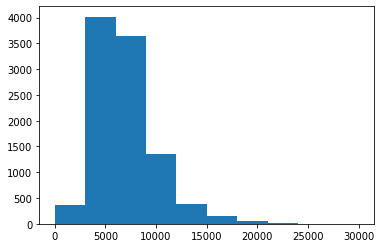

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(merged_df.Sales.sample(10000))

## Visualization

In [72]:
# visualize tree using plot_tree

from xgboost import plot_tree
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 60,60

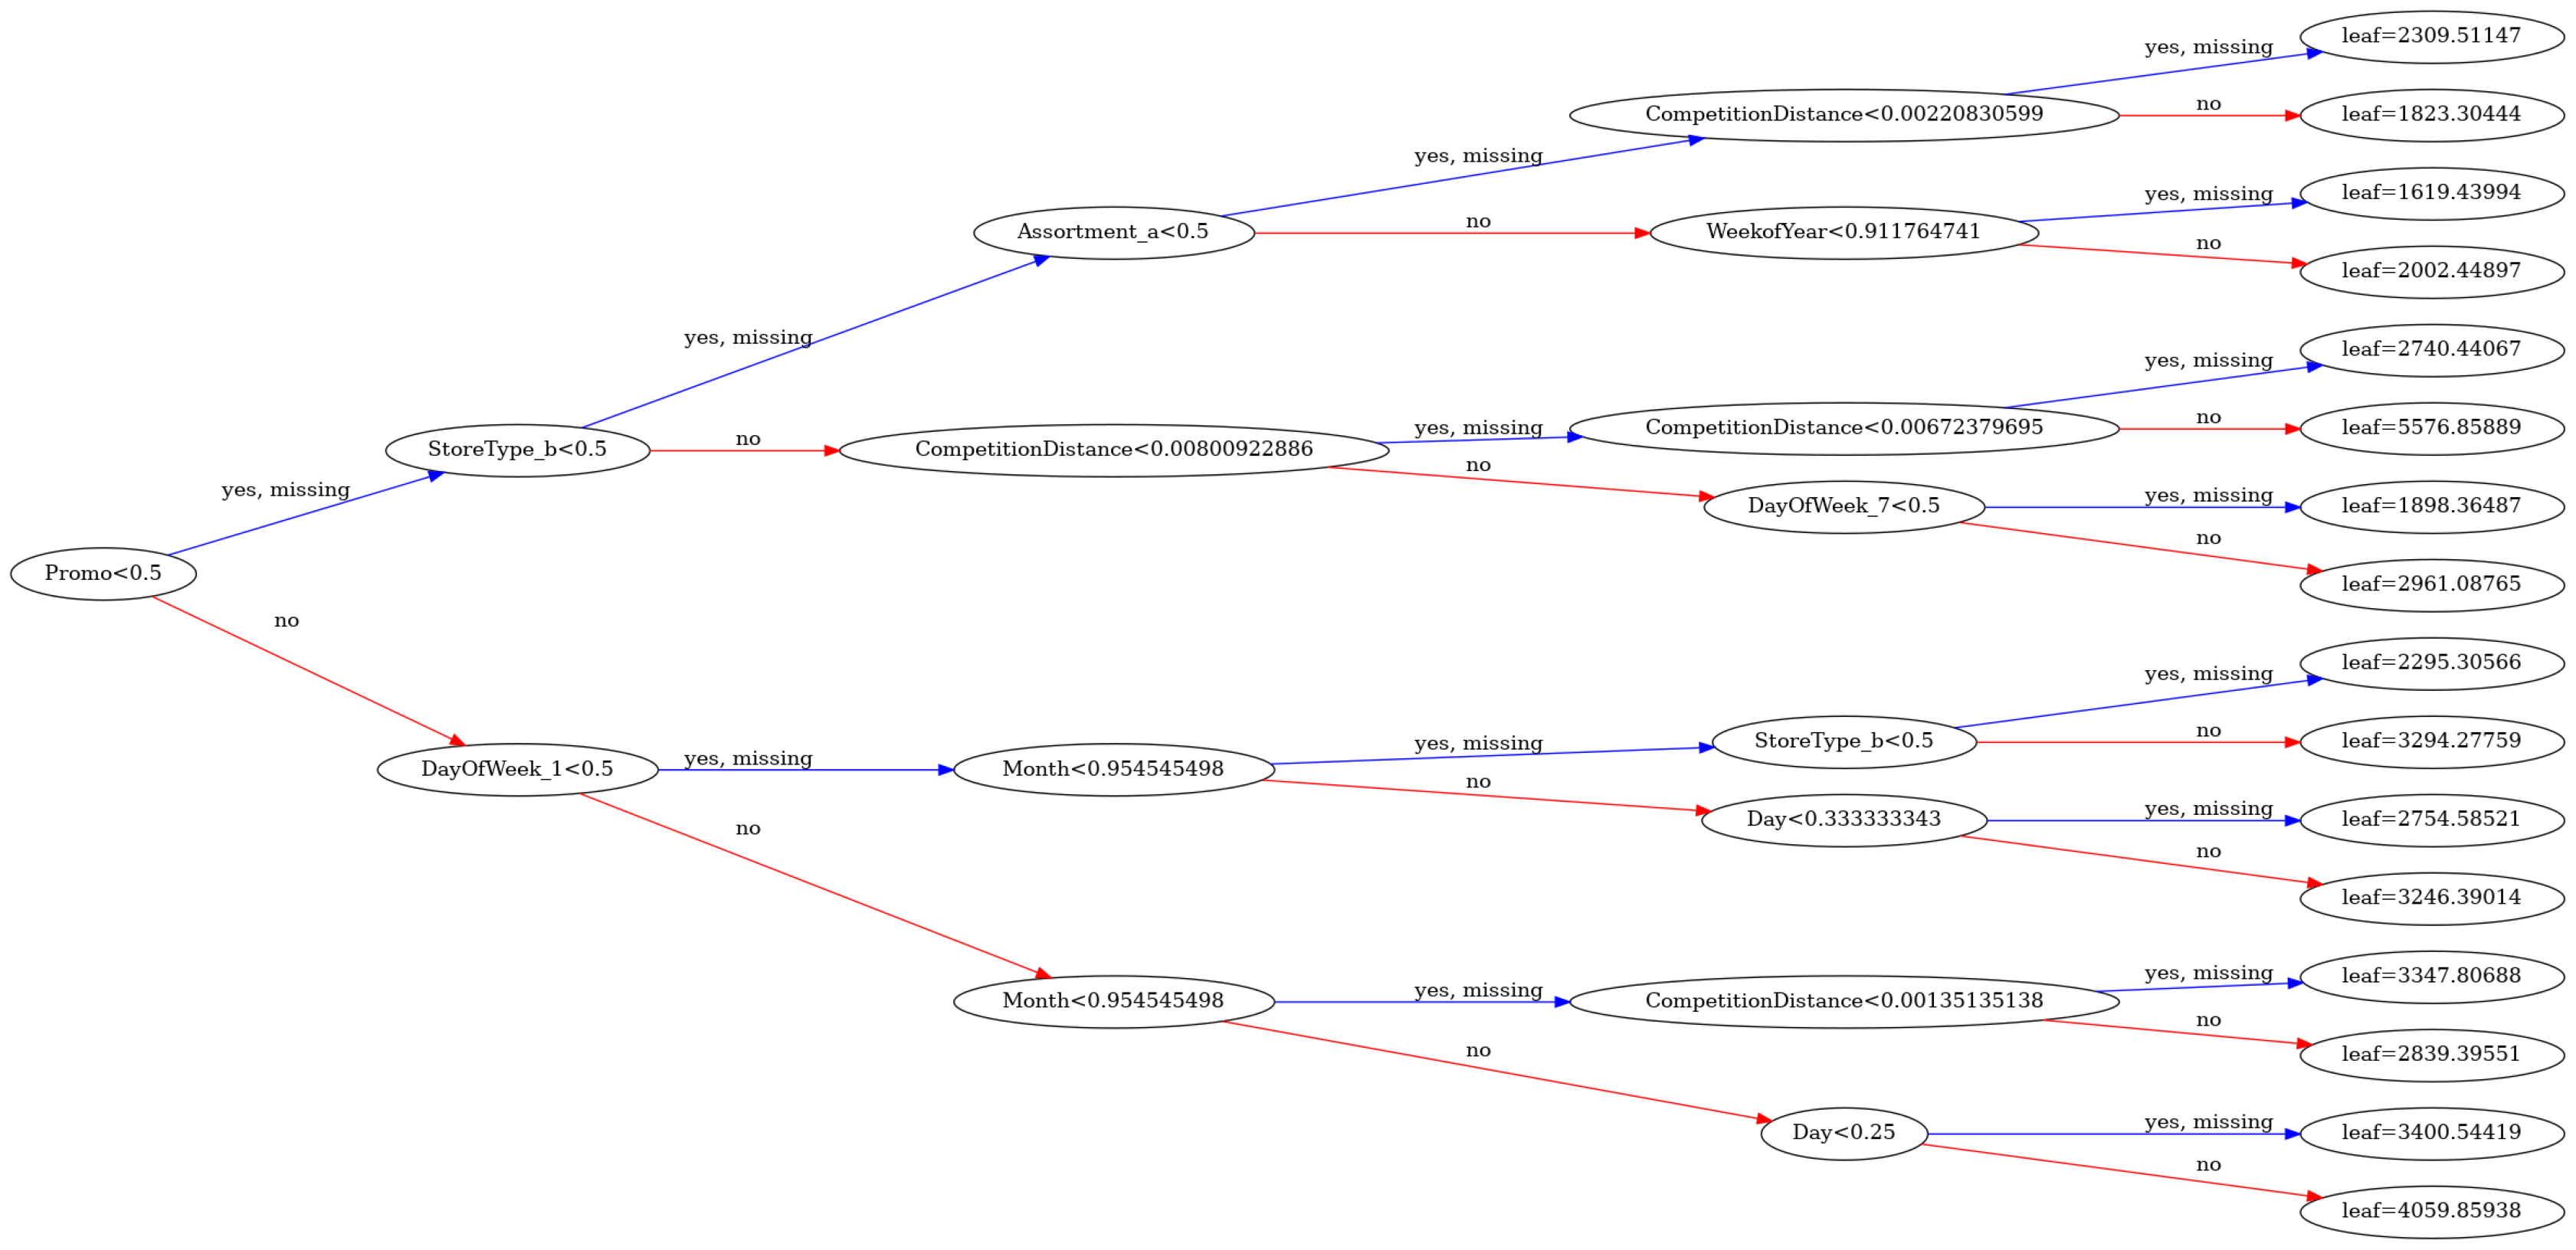

In [74]:
plot_tree(model, rankdir='LR', num_trees=0);

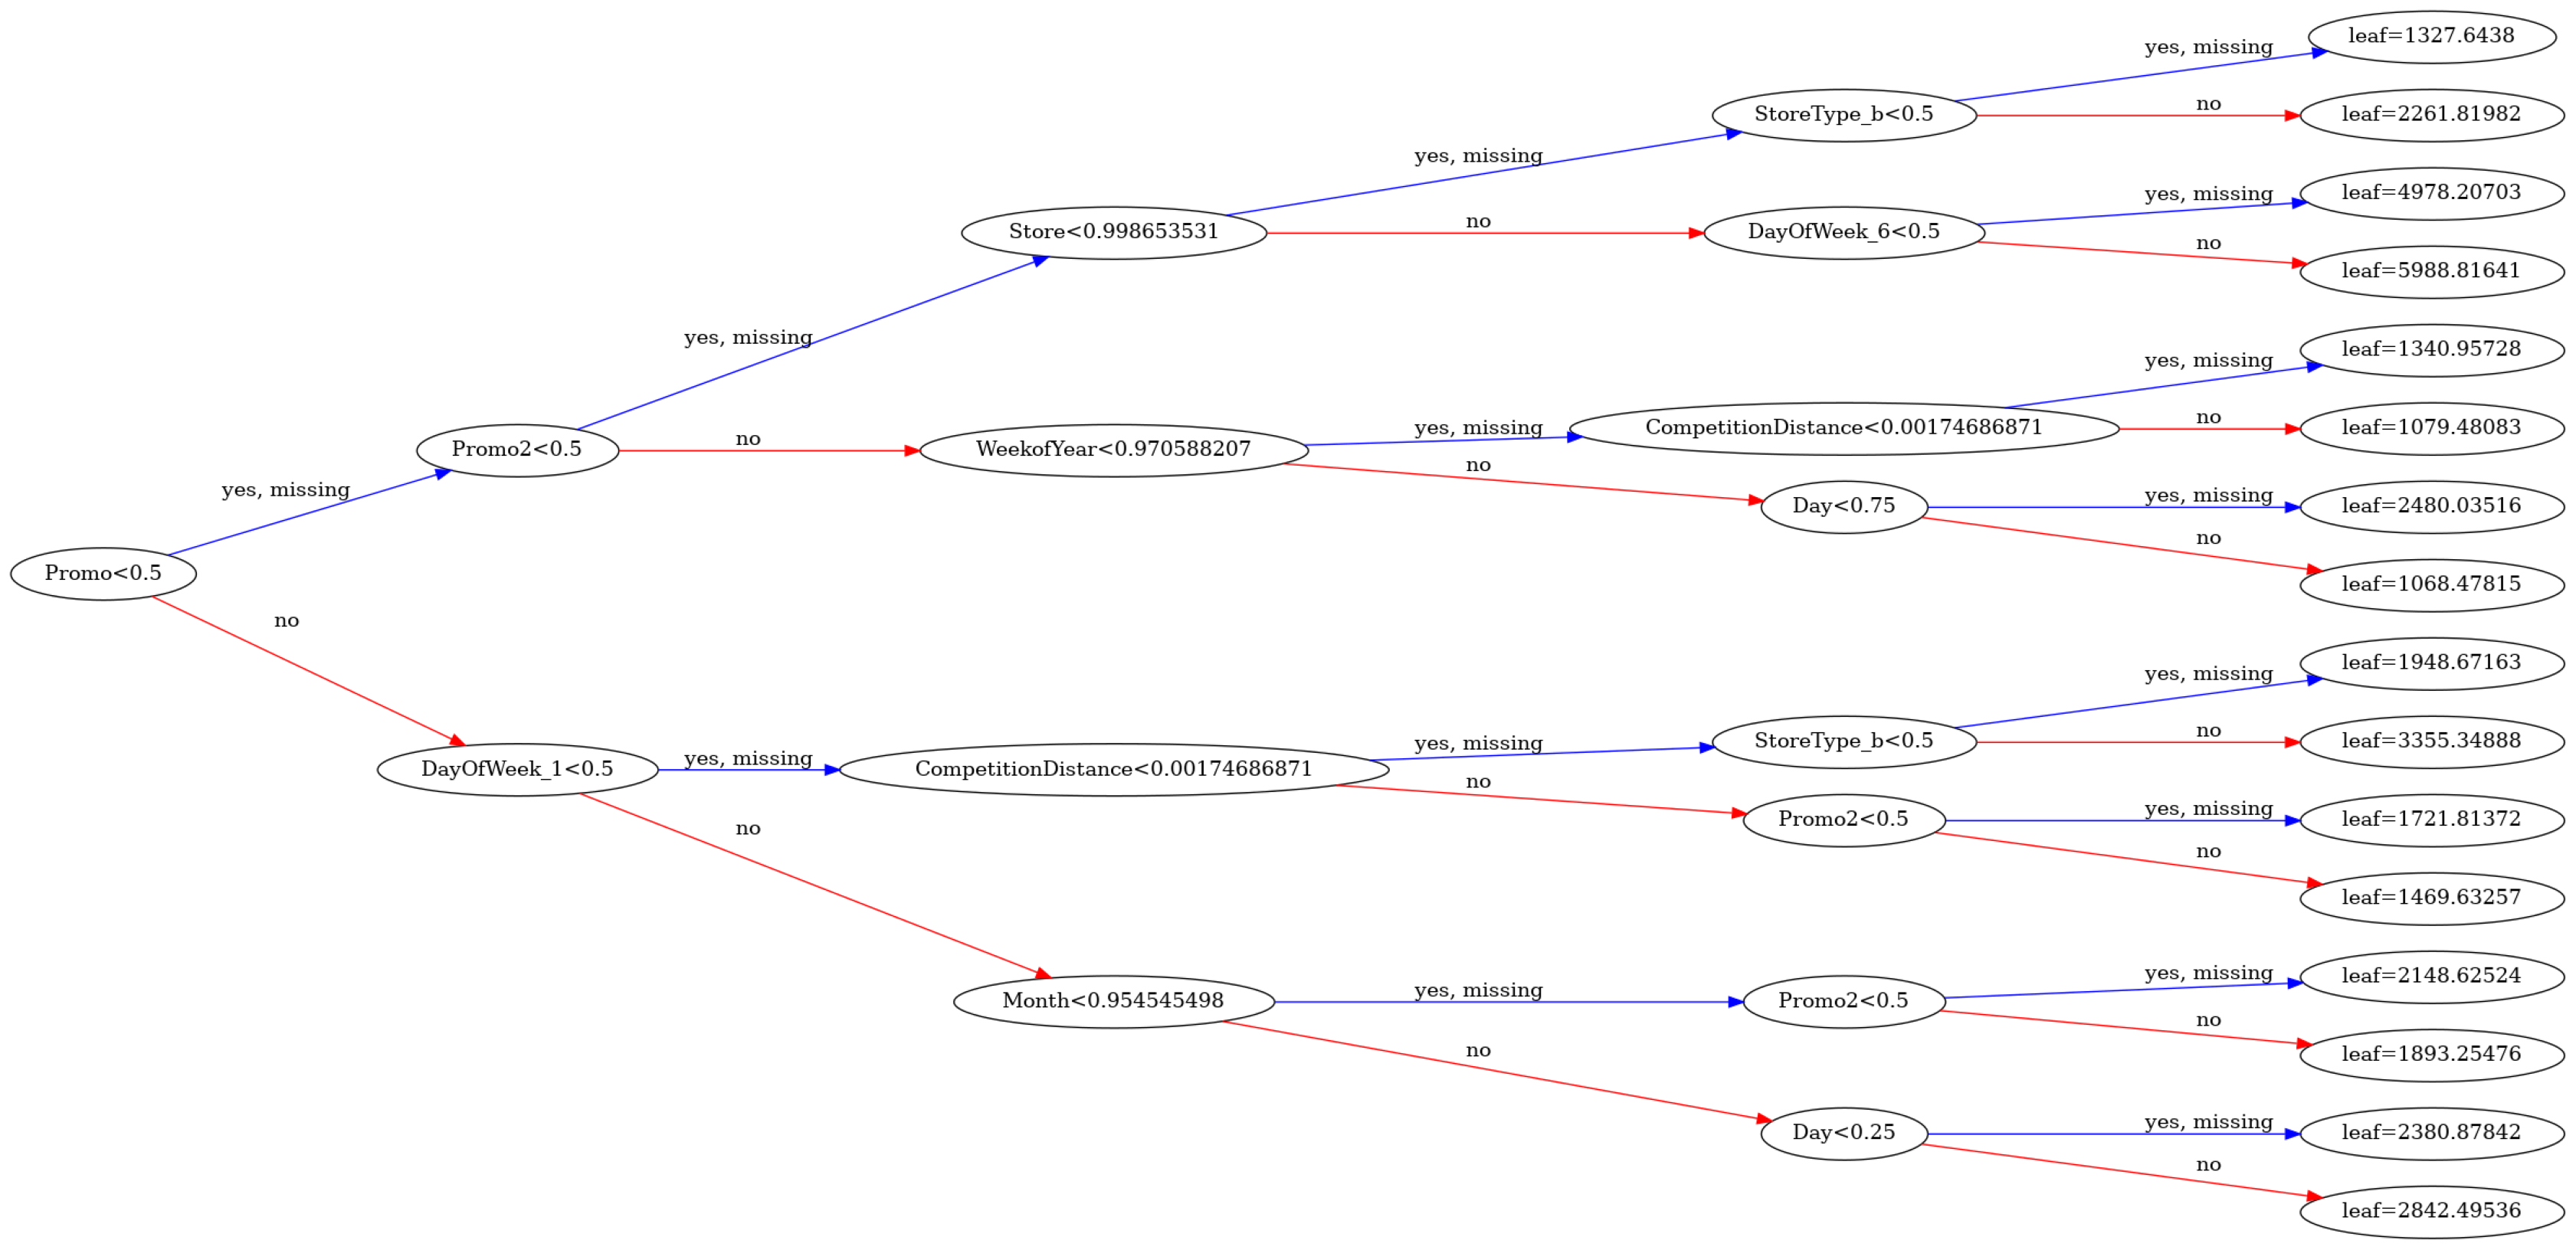

In [75]:
plot_tree(model, rankdir='LR', num_trees=1);

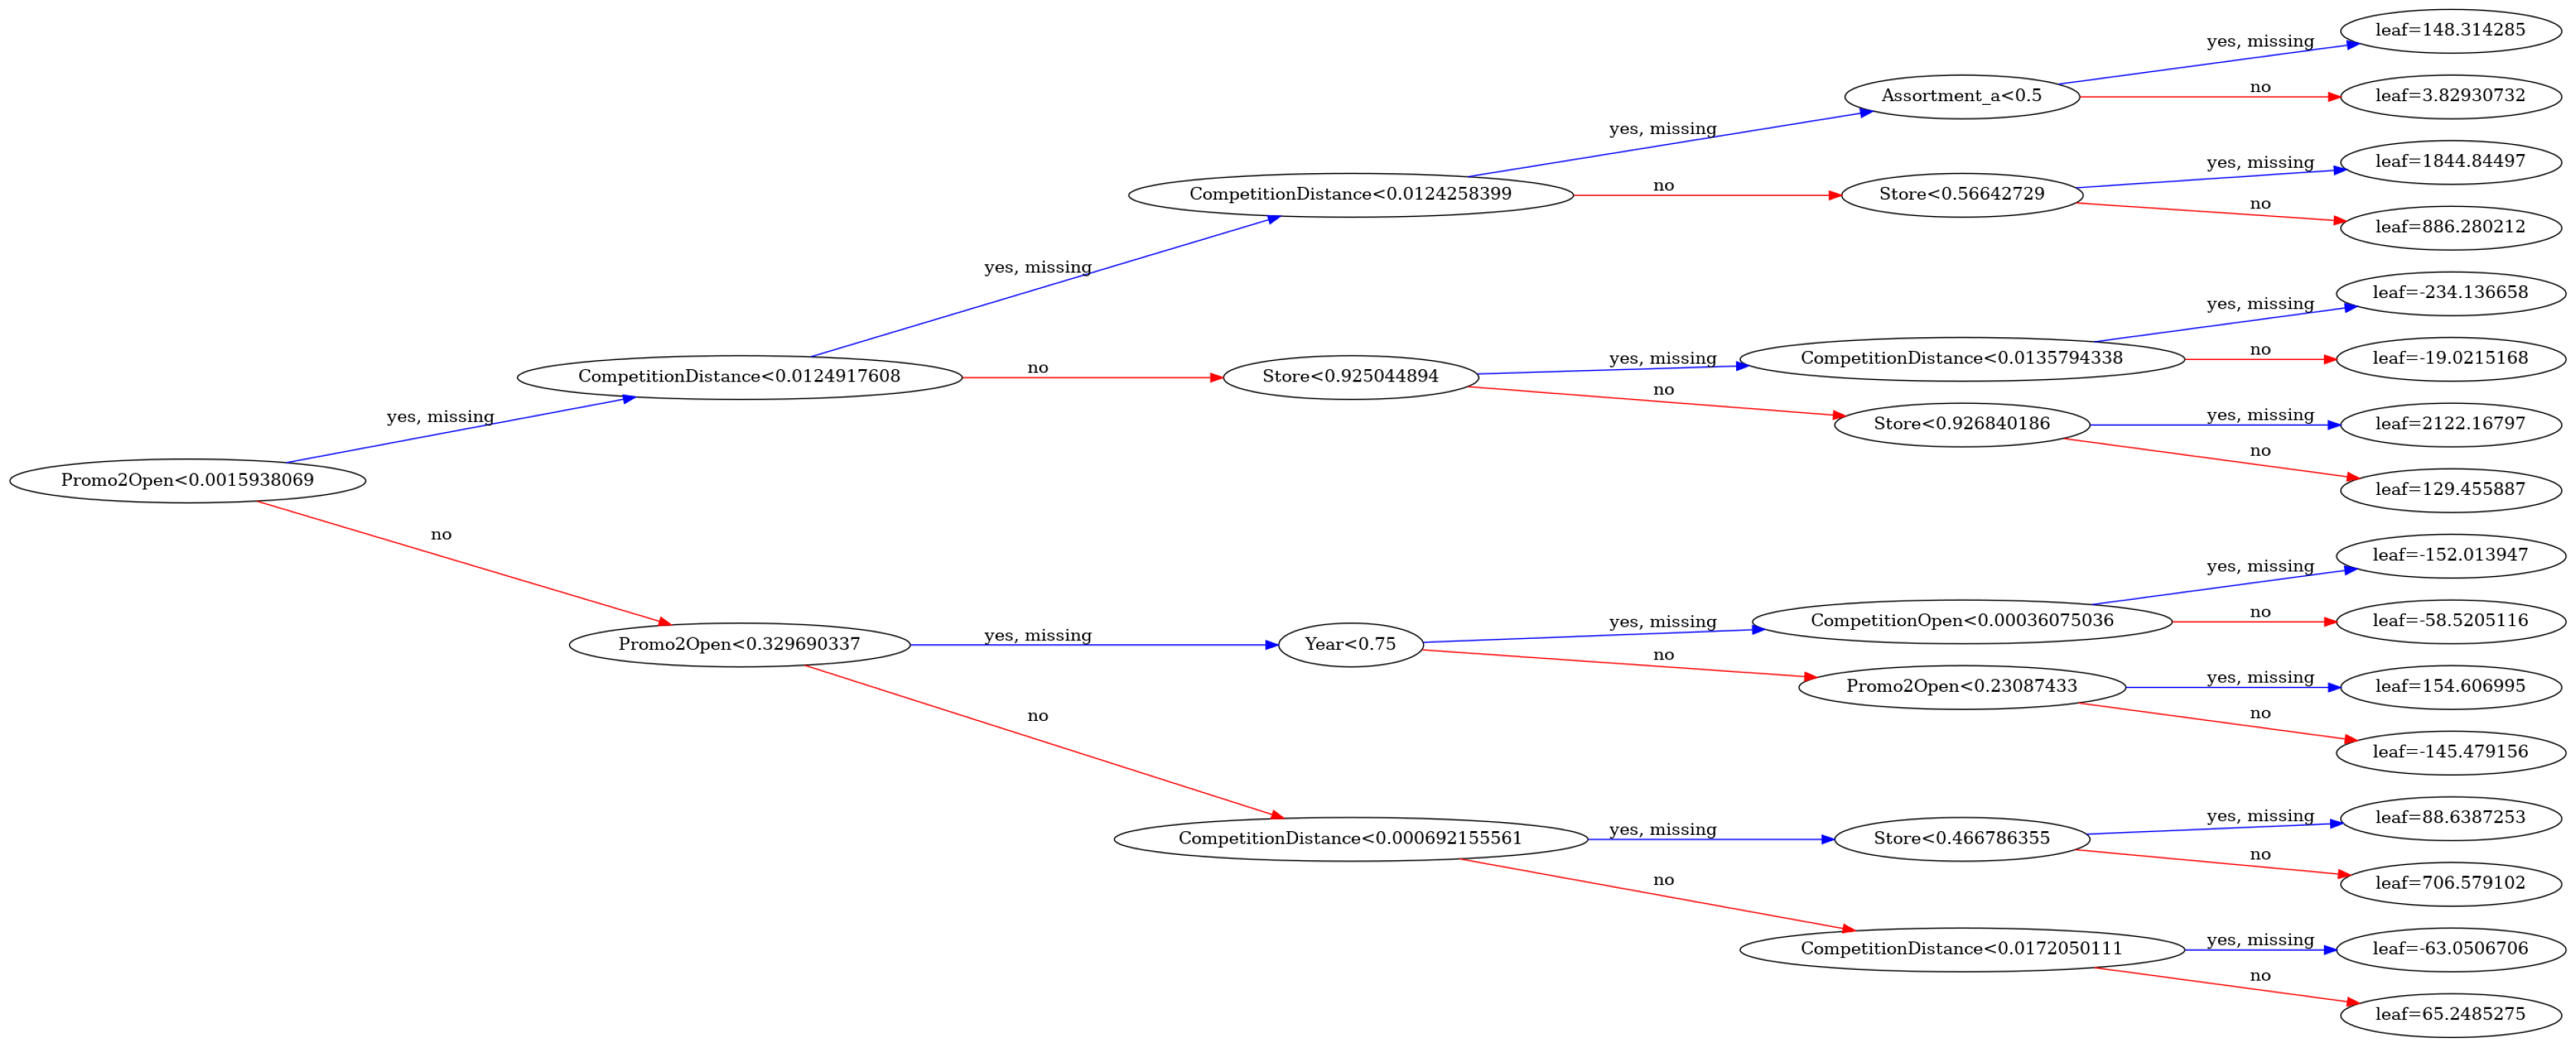

In [76]:
plot_tree(model, rankdir='LR', num_trees=19);

In [77]:
trees = model.get_booster().get_dump()

In [78]:
len(trees)

20

In [79]:
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.00220830599] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekofYear<0.911764741] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<0.00800922886] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.00672379695] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<0.954545498] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<0.333333343] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<0.954545498] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.00135135138] yes=27,no=28,missing=27
				27:le

## Feature Importance

In [81]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance':model.feature_importances_
}).sort_values('importance', ascending=False)

In [83]:
importance_df.head(10)

feature  importance
1                 Promo    0.317473
24          StoreType_b    0.086472
12          DayOfWeek_1    0.082269
5                Promo2    0.063986
3   CompetitionDistance    0.045053
29         Assortment_c    0.040226
27         Assortment_a    0.038759
9                 Month    0.038493
0                 Store    0.038119
8                   Day    0.033209

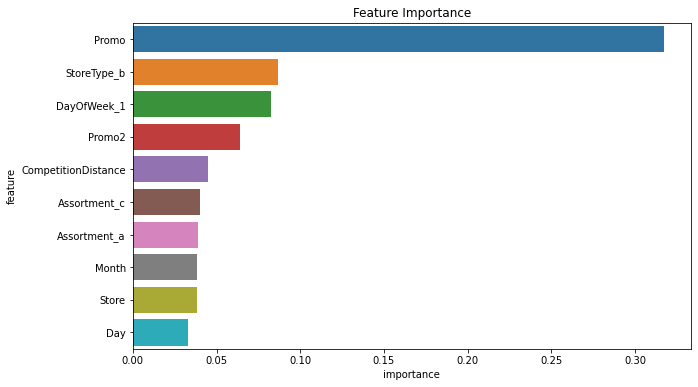

In [85]:
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## K Fold Cross Validation

![kfold](http://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png)

In [87]:
from sklearn.model_selection import KFold

In [91]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse
    

In [92]:
kfold = KFold(n_splits=5)

In [93]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2352.216448531526, Validation RMSE: 2424.6228916973314
Train RMSE: 2406.709513789309, Validation RMSE: 2451.9646038059277
Train RMSE: 2365.7354745443067, Validation RMSE: 2336.984157073758
Train RMSE: 2366.4732092777763, Validation RMSE: 2460.8995475901697
Train RMSE: 2379.3752997474626, Validation RMSE: 2440.665320626728


In [94]:
# define a function to average predictions from the 5 different models.
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [95]:
preds = predict_avg(models, X)

In [96]:
preds

array([8021.374 , 7577.715 , 8747.863 , ..., 7615.0303, 7924.784 ,
       9600.297 ], dtype=float32)

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

![hpt](https://i.imgur.com/EJCrSZw.png)

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [98]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [99]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [102]:

def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

### n_estimators

In [103]:
test_params(n_estimators=10)


Train RMSE: 2362.76195480308, Validation RMSE: 2348.702085349391


In [104]:
test_params(n_estimators=30)


Train RMSE: 1848.646131664556, Validation RMSE: 1839.8374140100673


In [105]:
test_params(n_estimators=100)


Train RMSE: 1189.0907835721493, Validation RMSE: 1182.191673835398


In [106]:
test_params(n_estimators=240)


Train RMSE: 900.8147134992857, Validation RMSE: 909.3936493978623


### max_depth

In [107]:
test_params(max_depth=2)


Train RMSE: 2337.546637614515, Validation RMSE: 2315.858142292135


In [108]:
test_params(max_depth=5)

Train RMSE: 1420.072022973741, Validation RMSE: 1411.0540606302004


In [109]:
test_params(max_depth=10)

Train RMSE: 687.2499006884119, Validation RMSE: 775.8096745259544


### learning_rate

In [110]:
test_params(n_estimators=50, learning_rate=0.01)


Train RMSE: 5044.48850172585, Validation RMSE: 5036.89440315394


In [111]:
test_params(n_estimators=50, learning_rate=0.1)


Train RMSE: 2200.172003242853, Validation RMSE: 2183.102936809057


In [112]:
test_params(n_estimators=50, learning_rate=0.3)


Train RMSE: 1541.0745464792515, Validation RMSE: 1529.8196486972695


In [113]:
test_params(n_estimators=50, learning_rate=0.9)


Train RMSE: 1121.9325695263058, Validation RMSE: 1123.541189011288


### Booster

In [114]:
test_params(booster='gblinear')


Train RMSE: 2730.688924077907, Validation RMSE: 2707.009329528743


# Putting it Together and Making Predictions


In [115]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)

In [116]:
%%time
model.fit(X, targets)

CPU times: user 1h 6min 23s, sys: 13.4 s, total: 1h 6min 36s
Wall time: 5min 49s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [117]:
test_preds = model.predict(X_test)

In [118]:
submission_df['Sales']  = test_preds


In [119]:
test_df.Open.isna().sum()


11

In [120]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)


In [121]:
submission_df

Id         Sales
0          1   3978.170898
1          2   7715.094727
2          3   8728.141602
3          4   7502.937012
4          5   7036.492676
...      ...           ...
41083  41084   2987.847168
41084  41085   6813.018066
41085  41086   6863.016602
41086  41087  23361.136719
41087  41088   6743.966797

[41088 rows x 2 columns]

In [122]:
submission_df.to_csv('submission.csv', index=None)
